In [47]:
import json
import pandas as pd

def merge(adata, kdata):
    i2k = {i: k for i, k in enumerate(adata.keys())}
    k2i = {k: i for i, k in i2k.items()}
    
    data = []
    
    for k, arr in adata.items():
        y = k2i[k]
        for d in arr:
            d['y'] = y
            data.append(d)
        
    for k, arr in kdata.items():
        y = k2i[k]
        for d in arr:
            d['y'] = y
            data.append(d)
            
    data = sorted(data, key=lambda d: d['y'])
    
    return i2k, k2i, pd.DataFrame(data)

with open('data-adult.json', 'r') as f:
    adata = json.load(f)
    
with open('data-kid.json', 'r') as f:
    kdata = json.load(f)
    
i2k, k2i, df = merge(adata, kdata)

print(f'df.shape={df.shape}')
print(f'i2k={i2k}')
print(f'k2i={k2i}')

df.shape=(61, 64)
i2k={0: 'rock', 1: 'paper', 2: 'scissor', 3: 'shoot'}
k2i={'rock': 0, 'paper': 1, 'scissor': 2, 'shoot': 3}


In [50]:
df[df.y == 0]

,index0x,index0y,index0z,index1x,index1y,index1z,index2x,index2y,index2z,index3x,...,thumb2x,thumb2y,thumb2z,thumb3x,thumb3y,thumb3z,palm0x,palm0y,palm0z,y
0,349.578839,208.643936,-1.560432,352.439455,188.406883,-26.908558,351.674205,207.871291,-39.925892,348.885063,...,359.231058,214.553182,-19.950230,343.523080,216.155982,-21.447109,324.598049,263.087435,-0.001338,0
1,305.131065,124.454536,-28.991688,306.755677,102.580983,-69.276756,303.595956,138.828739,-83.840683,299.208883,...,339.916115,153.776832,-63.609329,321.331416,132.088396,-79.458939,257.257173,229.327469,-0.001332,0
2,158.773676,82.646609,-5.766337,159.765429,40.940921,-32.083214,159.992507,85.545778,-44.660183,155.071858,...,183.126751,89.355526,-26.778191,142.798825,96.242297,-31.449377,122.790608,209.823352,-0.001537,0
3,186.887379,179.058348,-0.640768,195.456701,141.340018,-23.131060,192.954859,181.781597,-36.638947,187.109575,...,201.682485,179.758464,-13.834517,169.961367,189.428301,-15.042082,144.560222,285.308396,-0.001246,0
4,175.320364,319.547998,-15.010386,181.479897,286.382739,-38.390289,182.589255,319.128651,-47.276291,179.161383,...,201.528274,340.802234,-35.025547,179.092921,341.328167,-43.139572,138.709624,422.938807,-0.001237,0
5,339.109209,231.271260,6.871834,354.611722,207.798928,-8.144258,357.251188,233.996908,-11.055868,353.417675,...,373.852756,258.798590,-16.378742,361.016682,253.857059,-19.270851,306.281003,336.043696,-0.000530,0
6,451.479204,169.293096,-7.223790,454.375024,150.218435,-32.598331,452.052934,168.042686,-47.103077,449.064839,...,458.165232,174.571399,-29.870525,438.751649,170.867098,-34.375172,422.153921,221.673768,-0.001801,0
7,538.229106,318.087784,-5.405982,551.696353,315.376695,-31.787750,550.285884,334.526907,-34.865654,544.394399,...,563.575809,340.112020,-40.577316,556.338999,335.232621,-51.882397,523.229291,381.116374,-0.000412,0
8,541.007334,111.434752,-5.823825,549.193305,95.512411,-30.240664,545.636423,114.981229,-41.045475,540.524743,...,550.940912,116.745575,-24.008512,536.026287,114.405984,-26.866482,510.943010,162.262659,-0.001308,0
9,282.435237,130.949013,-6.282792,285.762223,85.533088,-23.519627,286.423172,121.183344,-33.463993,286.024584,...,305.175430,145.519315,-23.697075,281.490928,138.472092,-26.529615,236.018649,251.925798,-0.001177,0


In [49]:
def to_points(idx):
    s = df[[c for c in df.columns if c != 'y']].iloc[idx]
    pose = pd.DataFrame(list(zip(*(iter(s),) * 3)), columns=['x', 'y', 'z'])
    return {
        'thumb': pose.iloc[[0, 1, 2, 3, 4],:],
        'index': pose.iloc[[0, 5, 6, 7, 8],:],
        'middle': pose.iloc[[0, 9, 10, 11, 12],:],
        'ring': pose.iloc[[0, 13, 14, 15, 16],:],
        'pinky': pose.iloc[[0, 17, 18, 19, 20],:]
    }

pose = to_points(0)

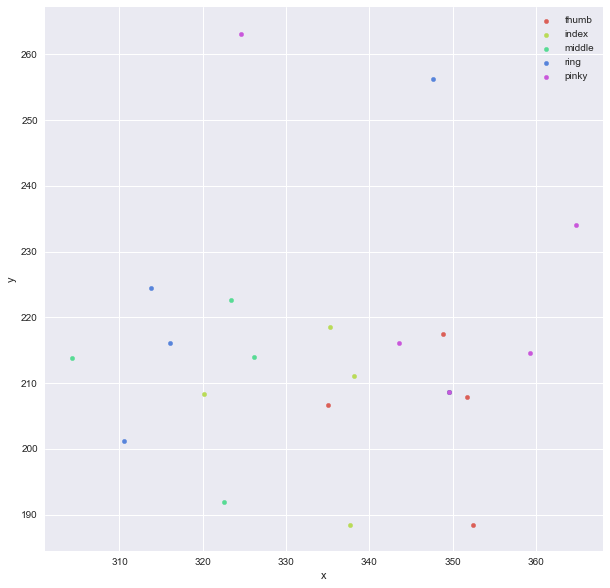

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(10, 10))

colors = sns.color_palette('hls', len(pose))

for i, finger in enumerate(['thumb', 'index', 'middle', 'ring', 'pinky']):
    pose[finger].plot.scatter(x='x', y='y', ax=ax, color=colors[i], label=f'{finger}')

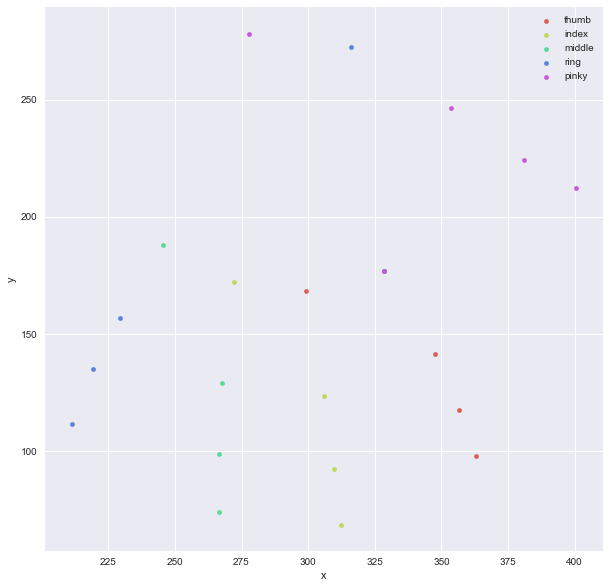

In [33]:
pose = to_points(11)

fig, ax = plt.subplots(figsize=(10, 10))

colors = sns.color_palette('hls', len(pose))

for i, finger in enumerate(['thumb', 'index', 'middle', 'ring', 'pinky']):
    pose[finger].plot.scatter(x='x', y='y', ax=ax, color=colors[i], label=f'{finger}')

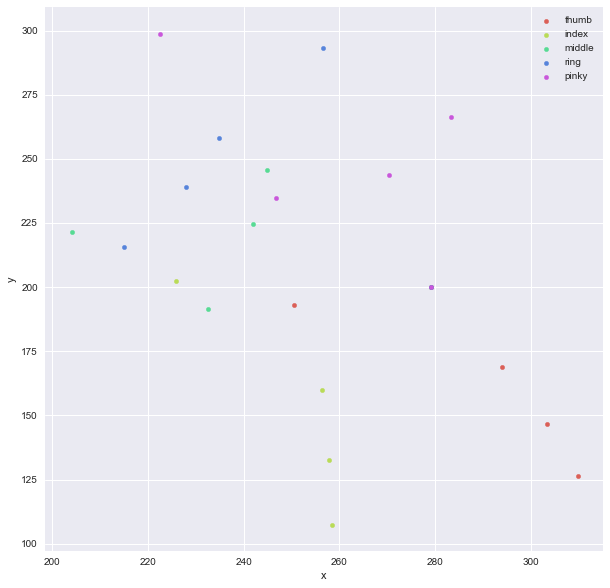

In [37]:
pose = to_points(20)

fig, ax = plt.subplots(figsize=(10, 10))

colors = sns.color_palette('hls', len(pose))

for i, finger in enumerate(['thumb', 'index', 'middle', 'ring', 'pinky']):
    pose[finger].plot.scatter(x='x', y='y', ax=ax, color=colors[i], label=f'{finger}')

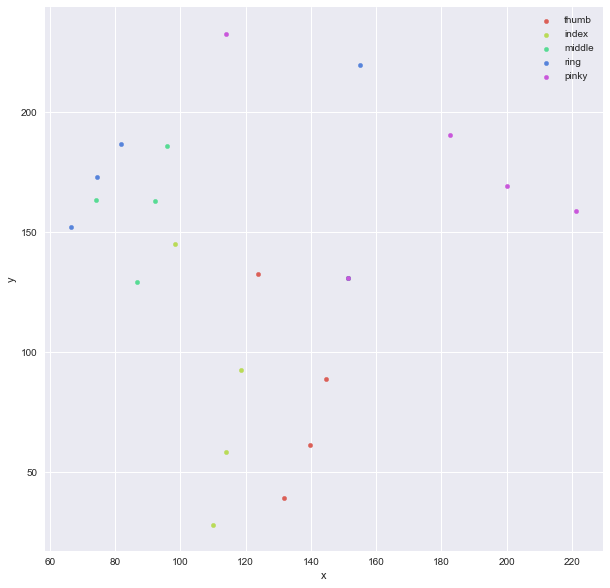

In [40]:
pose = to_points(29)

fig, ax = plt.subplots(figsize=(10, 10))

colors = sns.color_palette('hls', len(pose))

for i, finger in enumerate(['thumb', 'index', 'middle', 'ring', 'pinky']):
    pose[finger].plot.scatter(x='x', y='y', ax=ax, color=colors[i], label=f'{finger}')

In [51]:
from sklearn.linear_model import LogisticRegression

X = df[[c for c in df.columns if c != 'y']]
y = df.y

clf = LogisticRegression(random_state=37, max_iter=1000).fit(X, y)

In [52]:
clf.predict_proba(X)

array([[9.99857751e-01, 7.14828650e-05, 1.78647482e-07, 7.05878308e-05],
       [9.99999873e-01, 1.10509918e-09, 1.74693620e-16, 1.25734063e-07],
       [9.99996341e-01, 1.32614673e-09, 7.42270612e-12, 3.65778682e-06],
       [9.99990065e-01, 4.32103437e-08, 6.42518012e-10, 9.89129664e-06],
       [9.99969350e-01, 2.54127838e-07, 2.94577247e-10, 3.03959933e-05],
       [9.99960952e-01, 4.76835060e-07, 1.90433708e-06, 3.66669567e-05],
       [9.99971594e-01, 2.12520998e-05, 6.02742194e-09, 7.14765181e-06],
       [9.99749888e-01, 2.49903134e-04, 1.91304507e-09, 2.06685335e-07],
       [9.99953476e-01, 4.36434926e-05, 3.99399209e-09, 2.87674889e-06],
       [9.99974708e-01, 2.63393212e-08, 3.91232222e-10, 2.52653882e-05],
       [9.99956720e-01, 4.44109840e-09, 3.37111338e-08, 4.32422851e-05],
       [9.99988844e-01, 1.10322220e-05, 3.68991538e-10, 1.23561436e-07],
       [9.99992981e-01, 2.67520562e-09, 1.49354589e-08, 7.00089754e-06],
       [9.99999427e-01, 4.40712129e-09, 2.06789051e

In [53]:
clf.intercept_

array([ 1.66634455e-04,  5.83565461e-05,  4.73287228e-04, -6.98278229e-04])

In [54]:
clf.coef_

array([[ 4.49359407e-03, -1.81734867e-02,  5.81645429e-03,
         7.39588120e-03, -2.10527131e-02, -1.50079872e-02,
         4.91185171e-03,  1.59235332e-02, -2.05771592e-02,
        -1.15580482e-03,  4.12232921e-02, -1.06561819e-02,
        -3.85512263e-03, -1.47732408e-02,  7.37403587e-03,
         2.42256148e-03, -9.70206208e-03, -1.42494276e-02,
        -3.05747133e-04,  3.90269414e-02, -1.54120088e-02,
        -1.20658634e-02,  6.28192469e-02, -1.40912531e-03,
        -1.03702084e-02, -1.33034655e-02,  6.42252276e-03,
         9.11327021e-05, -1.65225949e-02, -7.67750553e-03,
         5.33904340e-03,  3.79865605e-04, -4.79637976e-03,
        -1.30558197e-03,  3.67898603e-04,  6.09192970e-03,
        -1.66972707e-02, -1.26294805e-02,  5.10300699e-03,
        -5.71081649e-03, -1.78150084e-02, -2.76401179e-03,
         9.93638686e-04, -6.82251353e-03,  2.35514586e-03,
        -4.49479317e-03, -4.39522768e-03,  1.34208812e-02,
         1.69634706e-02,  5.57458805e-03, -6.67758876e-0